    User_ID  Product_ID  Category  Price (Rs.)  Discount (%)  \
0  337c166f  f414122f-e    Sports        36.53            15   
1  d38a19bf  fde50f9c-5  Clothing       232.79            20   
2  d7f5f0b0  0d96fc90-3    Sports       317.02            25   
3  395d4994  964fc44b-d      Toys       173.19            25   
4  a83c145c  d70e2fc6-e    Beauty       244.80            20   

   Final_Price(Rs.) Payment_Method Purchase_Date  
0             31.05    Net Banking    12-11-2024  
1            186.23    Net Banking    09-02-2024  
2            237.76    Credit Card    01-09-2024  
3            129.89            UPI    01-04-2024  
4            195.84    Net Banking    27-09-2024  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3660 entries, 0 to 3659
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   User_ID           3660 non-null   object 
 1   Product_ID        3660 non-null   object 
 2   Category  

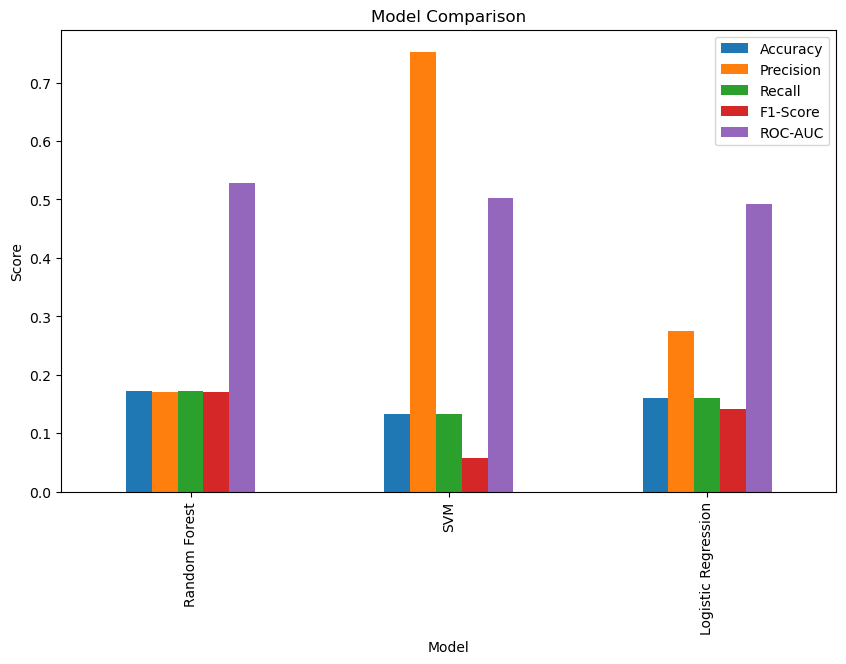

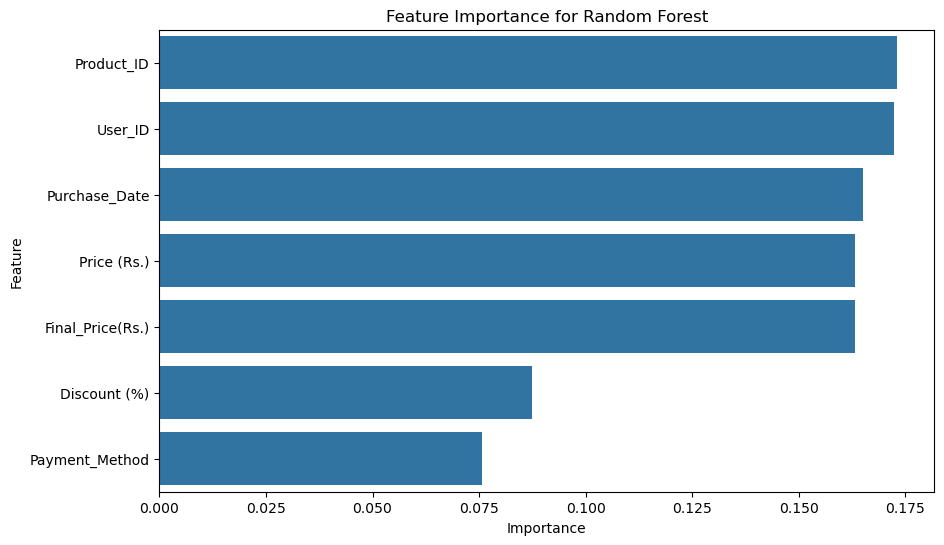

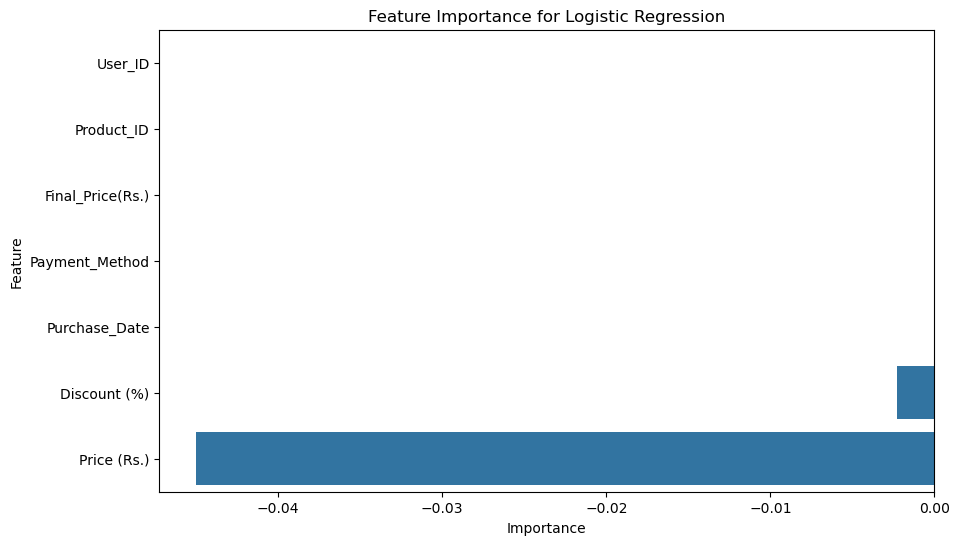

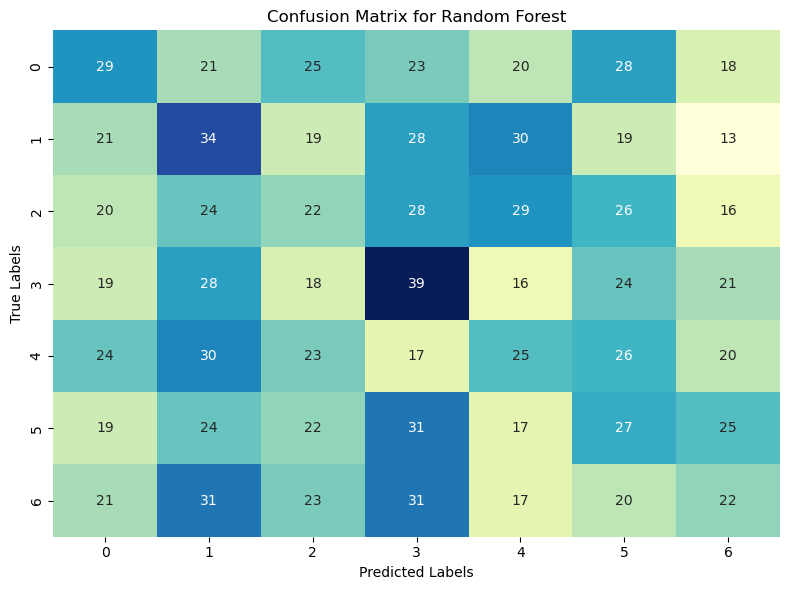

Metrics for Random Forest:
  Accuracy: 0.17
  Precision: 0.17
  Recall: 0.17
  F1-Score: 0.17


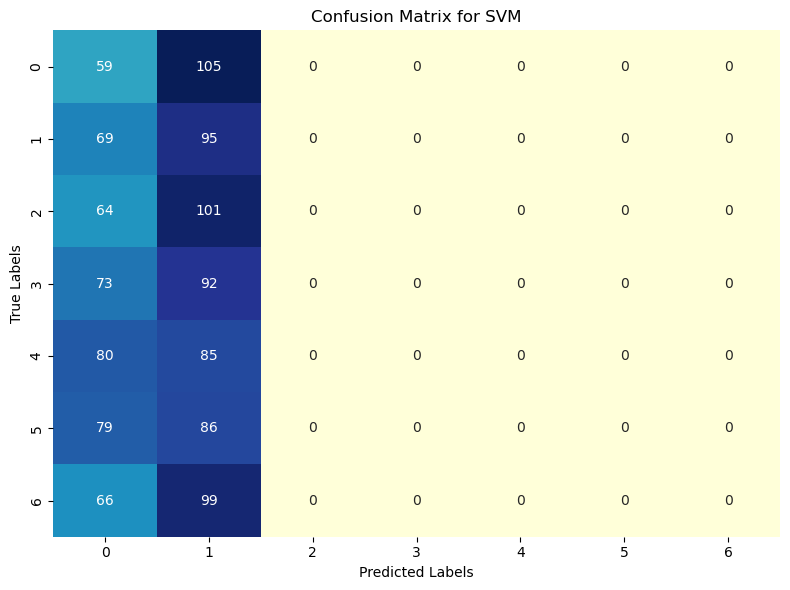

Metrics for SVM:
  Accuracy: 0.13
  Precision: 0.75
  Recall: 0.13
  F1-Score: 0.06


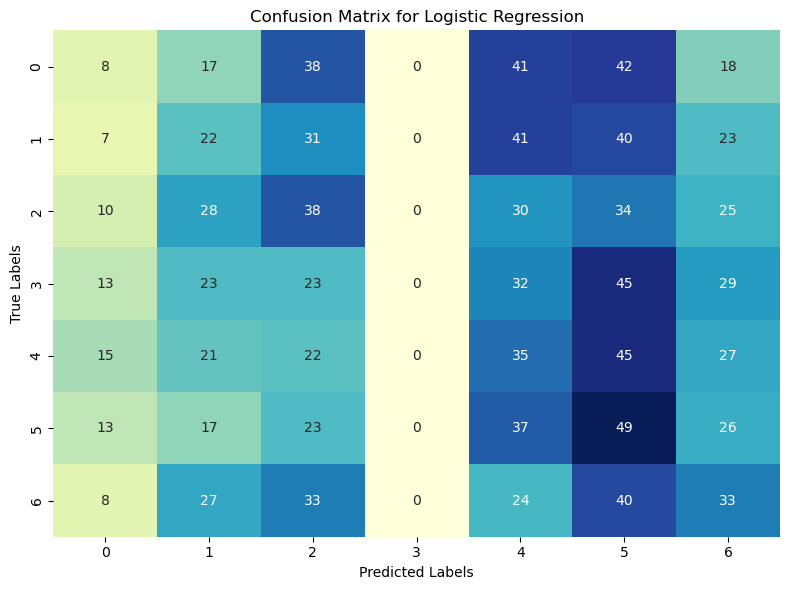

Metrics for Logistic Regression:
  Accuracy: 0.16
  Precision: 0.28
  Recall: 0.16
  F1-Score: 0.14


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import seaborn as sns
import warnings
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv("ecommerce_dataset_updated.csv")
  
warnings.filterwarnings("ignore", category=UserWarning, message=".*test scores are non-finite.*")


print(data.head())
print(data.info())
print(data.describe())


if data.isnull().sum().any():
    print("Missing values detected. Imputing missing values...")
    data.fillna(data.mean(), inplace=True)
else:
    print("No missing values detected.")


for column in data.select_dtypes(include=['object']).columns:
    encoder = LabelEncoder()
    data[column] = encoder.fit_transform(data[column])


X = data.drop("Category", axis=1)
y = data["Category"]

# Balance Dataset Using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)
X_train.isna().sum(), y_train.isna().sum()
X_train = X_train.fillna(X_train.mean())  
y_train = y_train.fillna(y_train.mean()) 

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


def evaluate_model_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)  
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)
    roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')  
    cm = confusion_matrix(y_test, y_pred)
    
    return accuracy, precision, recall, f1, roc_auc, cm


# Random Forest
rf = RandomForestClassifier(random_state=42)
rf_params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    
}
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring="roc_auc",verbose=1,n_jobs=-1)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_
rf_metrics = evaluate_model_matrix(best_rf, X_test, y_test)

# Support Vector Machine (SVM)
svm = SVC(probability=True, random_state=42)
svm_params = {
    "kernel": ["rbf", "linear"],
    "C": [0.1, 1, 10],
    "gamma": [0.001, 0.01, 0.1, 1]
}
svm_grid = GridSearchCV(svm, svm_params, cv=5, scoring="roc_auc",verbose=1,n_jobs=-1)
svm_grid.fit(X_train, y_train)
best_svm = svm_grid.best_estimator_
svm_metrics = evaluate_model_matrix(best_svm, X_test, y_test)

# Logistic Regression
lr = LogisticRegression(random_state=42, solver="saga")
lr_params = {
    "penalty": ["l1", "l2"],
    "C": [0.1, 1, 10],
}
lr_grid = GridSearchCV(lr, lr_params, cv=5, scoring="roc_auc",verbose=1,n_jobs=-1)
lr_grid.fit(X_train, y_train)
best_lr = lr_grid.best_estimator_
lr_metrics = evaluate_model_matrix(best_lr, X_test, y_test)


results = pd.DataFrame(
    {
        "Model": ["Random Forest", "SVM", "Logistic Regression"],
        "Accuracy": [rf_metrics[0], svm_metrics[0], lr_metrics[0]],
        "Precision": [rf_metrics[1], svm_metrics[1], lr_metrics[1]],
        "Recall": [rf_metrics[2], svm_metrics[2], lr_metrics[2]],
        "F1-Score": [rf_metrics[3], svm_metrics[3], lr_metrics[3]],
        "ROC-AUC": [rf_metrics[4], svm_metrics[4], lr_metrics[4]]
    }
)

print(results)


results.set_index("Model")[["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]].plot(
    kind="bar", figsize=(10, 6)
)
plt.title("Model Comparison")
plt.ylabel("Score")
plt.show()


for name, model in {"Random Forest": best_rf, "Logistic Regression": best_lr}.items():
    if name == "Random Forest":
       
        feature_importance_df = pd.DataFrame({
            "Feature": X.columns,
            "Importance": model.feature_importances_
        }).sort_values(by="Importance", ascending=False)
    elif name == "Logistic Regression":
        
        feature_importance_df = pd.DataFrame({
            "Feature": X.columns,
            "Importance": model.coef_[0]
        }).sort_values(by="Importance", ascending=False)
    

    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
    plt.title(f"Feature Importance for {name}")
    plt.show()


models = {"Random Forest": best_rf, "SVM": best_svm, "Logistic Regression": best_lr}

for name, model in models.items():
    accuracy, precision, recall, f1, roc_auc, cm = evaluate_model_matrix(model, X_test, y_test)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="YlGnBu",
        cbar=False
    )
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.tight_layout()
    plt.show()

    
    print(f"Metrics for {name}:")
    print(f"  Accuracy: {accuracy:.2f}")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall: {recall:.2f}")
    print(f"  F1-Score: {f1:.2f}")
  

